# GNN GCN Explainer

Creating a signed graph neural network based on a GCN kernal 


Training set has relative gene expression level (high or low), cell type, and cancerous.  
Goal: predict what is the cell type and what is it cancerous
- Node task: for each gene node, predict whether it’s a T-cell–type or B-cell–type marker in that sample (mask ignores CT nodes).
- Graph task: predict cancer status (wild-type=0 vs cancerous=1) using a masked mean pool over gene nodes.

What you’re training the model to do

Input features are just node IDs (learned embeddings) for gene and cell-type nodes.

Graph structure carries the signed up/down relations; the GCN mixes information along +/− edges (signed normalization keeps things stable).

Targets:

For genes: a single “LBL_<CellType>_UP/DOWN” token selected by a simple rule (prefer UP; fixed CT order breaks ties). This makes it a single-label node-classification toy.

For cell types: predict their own identity token (helps the model stabilize and use structure consistently).

You can expand this to multi-label (predict all CTs per gene) by switching the head to a sigmoid multilabel loss and building a multi-hot target, or to edge prediction by moving to a link-prediction setup—but this minimal version keeps things simple and trains fast.

## Text Prep/Tokenization

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt

In [76]:
cell_types = ["Tcells","Bcells"]
genes = ['CD3D','LCK','ZAP70','CD19'] #only focused on genes present
node_order = genes + [f'CT_{ct}' for ct in cell_types]   # genes first, then CT nodes
gene_mask = torch.tensor([1,1,1,1,0,0], dtype=torch.bool)
N = len(node_order) 

In [3]:
wild_type = {
    'Tcells':{'up': ['CD3D','LCK','ZAP70'],'down': ['CD19']},
    'Bcells':{'up': ['CD19'],'down': ['CD3D','LCK','ZAP70']},
  #  'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}

cancerous = {
    'Tcells':{'up': ['CD3D','ZAP70'],'down': ['CD19','LCK']},
    'Bcells':{'up': ['CD19','ZAP70'],'down': ['CD3D','LCK']},
   # 'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}

cancerous_2 = {
    'Tcells':{'up': ['ZAP70'],'down': ['CD19','CD3D','LCK']},
    'Bcells':{'up': ['CD19','ZAP70'],'down': ['CD3D','LCK']},
   # 'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}

cancerous_3 = {
    'Tcells':{'up': ['ZAP70','LCK'],'down': ['CD19','CD3D']},
    'Bcells':{'up': ['LCK','ZAP70'],'down': ['CD19','CD3D']},
   # 'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}

In [79]:
def build_vocab(genes, cell_types):
    toks = genes + [f"CT_{ct}" for ct in cell_types]
    stoi = {t:i for i,t in enumerate(toks)}; itos = {i:t for t,i in stoi.items()}
    return stoi, itos

stoi, itos = build_vocab(genes, cell_types)
vocab_size = len(stoi)

vocab_size, stoi

(6,
 {'CD3D': 0, 'LCK': 1, 'ZAP70': 2, 'CD19': 3, 'CT_Tcells': 4, 'CT_Bcells': 5})

In [80]:
def make_signed_adj_and_labels(spec, node_order, genes, cell_types, stoi):
    N = len(node_order)
    A = torch.zeros(N, N)
    def idx(n): return node_order.index(n)
    def add_edge(g, ct, s):
        i, j = idx(g), idx(f"CT_{ct}")
        A[i,j] = s; A[j,i] = s
    for ct in cell_types:
        for g in spec[ct].get('up', []):   add_edge(g, ct, +1)
        for g in spec[ct].get('down', []): add_edge(g, ct, -1)
    X_tokens = torch.tensor([stoi[n] for n in node_order], dtype=torch.long)
    y_node = torch.full((N,), -1, dtype=torch.long)   # -1 = ignore (CT nodes)
    # per-gene cell-type label: 0=Tcells, 1=Bcells; rule: prefer UP; tie-break by order T then B; fallback from DOWN (invert)
    for g in genes:
        t_up = g in spec['Tcells'].get('up', []); b_up = g in spec['Bcells'].get('up', [])
        t_dn = g in spec['Tcells'].get('down', []); b_dn = g in spec['Bcells'].get('down', [])
        lab = None
        if t_up and not b_up: lab = 0
        elif b_up and not t_up: lab = 1
        elif t_up and b_up: lab = 0
        else:
            if t_dn and not b_dn: lab = 1
            elif b_dn and not t_dn: lab = 0
        if lab is not None: y_node[idx(g)] = lab
    return X_tokens, y_node, A

In [81]:
graphs = [wild_type, cancerous, cancerous_2, cancerous_3]
x_list, y_node_list, a_list = [], [], []

In [83]:
for spec in graphs:
    x_i, y_i, a_i = make_signed_adj_and_labels(spec, node_order, genes, cell_types, stoi)
    x_list.append(x_i); y_node_list.append(y_i); a_list.append(a_i.float())

x_list, y_node_list

NameError: name 'X_i' is not defined

In [6]:
# ----- assemble batch for SimpleGCNText -----
X1, Y1, A1 = make_graph_tensors(wild_type, genes, cell_types, node_order, stoi)
X1, Y1, A1

(tensor([0, 1, 2, 3, 4, 5]),
 tensor([6, 6, 6, 8, 4, 5]),
 tensor([[ 0.,  0.,  0.,  0.,  1., -1.],
         [ 0.,  0.,  0.,  0.,  1., -1.],
         [ 0.,  0.,  0.,  0.,  1., -1.],
         [ 0.,  0.,  0.,  0., -1.,  1.],
         [ 1.,  1.,  1., -1.,  0.,  0.],
         [-1., -1., -1.,  1.,  0.,  0.]]))

In [7]:
X2, Y2, A2 = make_graph_tensors(cancerous, genes, cell_types, node_order, stoi)
X2, Y2, A2

(tensor([0, 1, 2, 3, 4, 5]),
 tensor([6, 7, 6, 8, 4, 5]),
 tensor([[ 0.,  0.,  0.,  0.,  1., -1.],
         [ 0.,  0.,  0.,  0., -1., -1.],
         [ 0.,  0.,  0.,  0.,  1.,  1.],
         [ 0.,  0.,  0.,  0., -1.,  1.],
         [ 1., -1.,  1., -1.,  0.,  0.],
         [-1., -1.,  1.,  1.,  0.,  0.]]))

In [8]:
X3, Y3, A3 = make_graph_tensors(cancerous_2, genes, cell_types, node_order, stoi)
X3, Y3, A3

(tensor([0, 1, 2, 3, 4, 5]),
 tensor([7, 7, 6, 8, 4, 5]),
 tensor([[ 0.,  0.,  0.,  0., -1., -1.],
         [ 0.,  0.,  0.,  0., -1., -1.],
         [ 0.,  0.,  0.,  0.,  1.,  1.],
         [ 0.,  0.,  0.,  0., -1.,  1.],
         [-1., -1.,  1., -1.,  0.,  0.],
         [-1., -1.,  1.,  1.,  0.,  0.]]))

In [9]:
X4, Y4, A4 = make_graph_tensors(cancerous_3, genes, cell_types, node_order, stoi)
X4, Y4, A4

(tensor([0, 1, 2, 3, 4, 5]),
 tensor([7, 6, 6, 7, 4, 5]),
 tensor([[ 0.,  0.,  0.,  0., -1., -1.],
         [ 0.,  0.,  0.,  0.,  1.,  1.],
         [ 0.,  0.,  0.,  0.,  1.,  1.],
         [ 0.,  0.,  0.,  0., -1., -1.],
         [-1.,  1.,  1., -1.,  0.,  0.],
         [-1.,  1.,  1., -1.,  0.,  0.]]))

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

def graph_from_adjacency(A, node_order, genes):
    G = nx.Graph()
    for n in node_order:
        G.add_node(n, bipartite=(0 if n in genes else 1))
    N = len(node_order)
    for i in range(N):
        for j in range(i+1, N):
            s = float(A[i, j])
            if s != 0:
                G.add_edge(node_order[i], node_order[j], sign=int(s))
    return G

def draw_signed_bipartite(G, node_order, genes, ax=None, title=''):
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 4))
    left  = [n for n,d in G.nodes(data=True) if d['bipartite'] == 0]
    right = [n for n,d in G.nodes(data=True) if d['bipartite'] == 1]

    # Simple 2-column bipartite layout
    pos = {}
    for i, n in enumerate(left):  pos[n] = (0.0, i)
    for j, n in enumerate(right): pos[n] = (1.0, j)

    # Nodes
    nx.draw_networkx_nodes(G, pos, nodelist=left,  node_shape='o', ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=right, node_shape='s', ax=ax)

    # Edges: solid for + (upregulated), dashed for - (downregulated)
    pos_edges = [(u,v) for u,v,d in G.edges(data=True) if d['sign'] > 0]
    neg_edges = [(u,v) for u,v,d in G.edges(data=True) if d['sign'] < 0]
    nx.draw_networkx_edges(G, pos, edgelist=pos_edges, style='solid',  ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=neg_edges, style='dashed', ax=ax)

    # Labels
    nx.draw_networkx_labels(G, pos, font_size=9, ax=ax)

    # Legend proxies
    from matplotlib.lines import Line2D
    ax.legend(
        [Line2D([0],[0], linestyle='solid'),
         Line2D([0],[0], linestyle='dashed')],
        ['upregulated (+)', 'downregulated (−)'], loc='upper right', frameon=False
    )
    ax.set_title(title)
    ax.axis('off')
    return ax

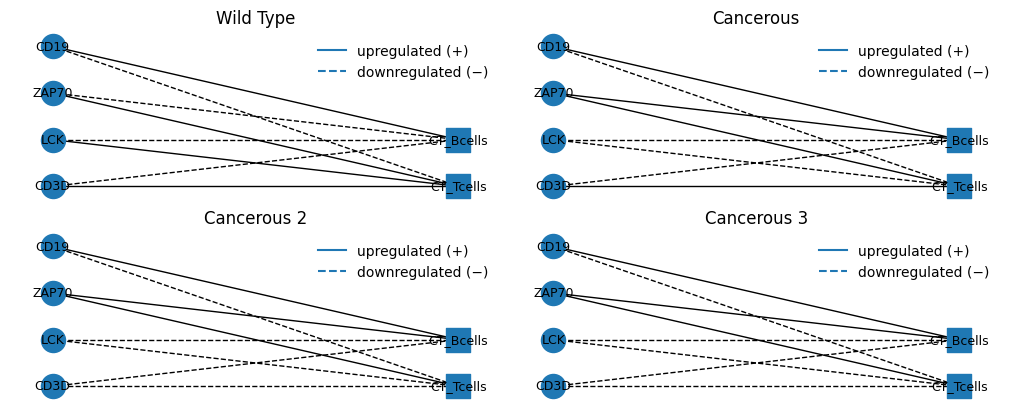

In [11]:
# Build and draw both graphs
G1 = graph_from_adjacency(A1, node_order, genes)
G2 = graph_from_adjacency(A2, node_order, genes)
G3 = graph_from_adjacency(A3, node_order, genes)
G4 = graph_from_adjacency(A4, node_order, genes)

fig, axes = plt.subplots(2, 2, figsize=(10, 4), constrained_layout=True)
draw_signed_bipartite(G1, node_order, genes, ax=axes[0,0], title='Wild Type')
draw_signed_bipartite(G2, node_order, genes, ax=axes[0,1], title='Cancerous')
draw_signed_bipartite(G3, node_order, genes, ax=axes[1,0], title='Cancerous 2')
draw_signed_bipartite(G3, node_order, genes, ax=axes[1,1], title='Cancerous 3')
plt.show()


# Modeling

A machine learning model forward pass now uses the tokenization information, runs several layers of linear algebra on it, and then "predicts" the probability that each token in the vocab is next. When it is noisy (like you will see in this example), this process results in gibberish.  The training process changes the noise to pattern during the "backward pass" as you'll see. We'll show 3 steps that are focused on training:
1. **Data Loading** `x, y = train_loader.next_batch()` - this step pulls from the raw data enough tokens to complete a forward pass and loss calculation.  If the model is inference only, this step is replaced with taking in the inference input and preparing it similarly as the forward pass.
2. **Forward Pass** `logits, loss = model(x, y)` - using the data and the model architecture we run a prediction for the tokens. When training we also compare against the expected to get loss, but in inference, we use the logits to complete the inference task.
3. **Back Propagation, aka Backward Pass & Training** `loss.backward(); optimizer.step()` - using differentials to understand what parameters most impact the forward pass' impact on its prediction, comparing that against what is actually right based on the data loading step, and then making very minor adjustments to the impactful parameters with the hope it improves future predictions.

The we'll show a final **Forward Pass** with the updated weights we did in #3. 

## Data Loading

To start, we need to get enough data to run the forward and backward passes.  Since our total dataset is likely too big to be held in memory all at once in real practice, we will read just enough file information into memory so that we can run the passes, leaving memory and compute to be used on the passes instead of static data holding. 
To start, we have to identify the batch size and the model context length to determine how much data we need.  Consequently, these dimensions also form 2 of the 3 dimensions in the initial matrix.
- **Batch Size (B)** - This is the number of examples you'll train on in a single pass. 
- **Number of Nodes (N)** - This is basically the "context length" for a GNN.  This is the max number of node that a model can use in a pass.

Beyond these, in a GCN, the depth also controls how much "context" or complexity can be learned. This is because each GCN layer learns 1 hop, or 1 relationship of neighbors. This means that after $L$ layers, a model can learn $L$-hops worth of context.

In our case we'll set our Batch to be our 2 examples, nodes to the the nodes we have configured, 10, and our GCN will have 2 layers to model 2 network hops: gene → cell type → other genes

In [12]:
x_tokens = torch.stack([X1, X2, X3, X4], dim=0)     # [B=2, N=10]
x_tokens

tensor([[0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5]])

In [13]:
y_labels = torch.stack([Y1, Y2, Y3, Y4], dim=0)     # [2, 10]
y_labels

tensor([[6, 6, 6, 8, 4, 5],
        [6, 7, 6, 8, 4, 5],
        [7, 7, 6, 8, 4, 5],
        [7, 6, 6, 7, 4, 5]])

In [14]:
B_batch, N_nodes = x_tokens.shape
B_batch, N_nodes

(4, 6)

### Create and normalize Graph

In [15]:
a_list   = [A1.float(), A2.float(),A3.float(),A4.float()]         # list of [10,10] signed adjacencies
a_list

[tensor([[ 0.,  0.,  0.,  0.,  1., -1.],
         [ 0.,  0.,  0.,  0.,  1., -1.],
         [ 0.,  0.,  0.,  0.,  1., -1.],
         [ 0.,  0.,  0.,  0., -1.,  1.],
         [ 1.,  1.,  1., -1.,  0.,  0.],
         [-1., -1., -1.,  1.,  0.,  0.]]),
 tensor([[ 0.,  0.,  0.,  0.,  1., -1.],
         [ 0.,  0.,  0.,  0., -1., -1.],
         [ 0.,  0.,  0.,  0.,  1.,  1.],
         [ 0.,  0.,  0.,  0., -1.,  1.],
         [ 1., -1.,  1., -1.,  0.,  0.],
         [-1., -1.,  1.,  1.,  0.,  0.]]),
 tensor([[ 0.,  0.,  0.,  0., -1., -1.],
         [ 0.,  0.,  0.,  0., -1., -1.],
         [ 0.,  0.,  0.,  0.,  1.,  1.],
         [ 0.,  0.,  0.,  0., -1.,  1.],
         [-1., -1.,  1., -1.,  0.,  0.],
         [-1., -1.,  1.,  1.,  0.,  0.]]),
 tensor([[ 0.,  0.,  0.,  0., -1., -1.],
         [ 0.,  0.,  0.,  0.,  1.,  1.],
         [ 0.,  0.,  0.,  0.,  1.,  1.],
         [ 0.,  0.,  0.,  0., -1., -1.],
         [-1.,  1.,  1., -1.,  0.,  0.],
         [-1.,  1.,  1., -1.,  0.,  0.]])]

**Normalize**

The signed, symmetrically normalized adjacency keeps message-passing **well-scaled and stable** across nodes with very different degrees, improves **convergence** and **gradient flow**, and (with signs) lets the model use **inhibitory (negative) as well as excitatory (positive)** relations without blowing up or collapsing activations.

**What it’s doing.** It first adds self-loops $\hat A = A + I$ so each node preserves its own features, then computes degrees from magnitudes $\deg_i=\sum_j |\hat A_{ij}|$ (so negative edges don’t cancel connectivity), and forms

$$
\tilde A = D^{-\tfrac12},\hat A,D^{-\tfrac12} \newline
\text{so}\\
\quad w_{ij}=\frac{\hat A_{ij}}{\sqrt{\deg_i,\deg_j}}.
$$

This makes neighbor messages **degree-normalized averages** (with sign), yields a **symmetric** propagation operator with **bounded spectral norm**, and thus keeps features on a comparable scale over layers while still encoding up- vs down-regulation via the sign of $\hat A_{ij}$.

In [16]:
Apos_norms, Aneg_norms = [], []

In [17]:
A = a_list[0]
A

tensor([[ 0.,  0.,  0.,  0.,  1., -1.],
        [ 0.,  0.,  0.,  0.,  1., -1.],
        [ 0.,  0.,  0.,  0.,  1., -1.],
        [ 0.,  0.,  0.,  0., -1.,  1.],
        [ 1.,  1.,  1., -1.,  0.,  0.],
        [-1., -1., -1.,  1.,  0.,  0.]])

In [18]:
A_pos = torch.clamp(A, min=0)  
A_neg = torch.clamp(-A, min=0)  
A_pos, A_neg

(tensor([[0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0.],
         [1., 1., 1., 0., -0., -0.]]))

In [19]:
I = torch.eye(N_nodes)
I

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]])

In [20]:
A_pos_hat = A_pos + I
A_neg_hat = A_neg + I
A_pos_hat, A_neg_hat

(tensor([[1., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 1., 0.],
         [0., 0., 1., 0., 1., 0.],
         [0., 0., 0., 1., 0., 1.],
         [1., 1., 1., 0., 1., 0.],
         [0., 0., 0., 1., 0., 1.]]),
 tensor([[1., 0., 0., 0., 0., 1.],
         [0., 1., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 1.],
         [0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 1., 1., 0.],
         [1., 1., 1., 0., 0., 1.]]))

In [21]:
deg_pos = torch.clamp(torch.abs(A_pos_hat).sum(1), min=1e-6)
deg_neg = torch.clamp(torch.abs(A_neg_hat).sum(1), min=1e-6)
deg_pos, deg_neg

(tensor([2., 2., 2., 2., 4., 2.]), tensor([2., 2., 2., 2., 2., 4.]))

In [22]:
D_pos_inv_sqrt = torch.diag(deg_pos.rsqrt())
D_neg_inv_sqrt = torch.diag(deg_neg.rsqrt())
D_pos_inv_sqrt, D_neg_inv_sqrt

(tensor([[0.7071, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.7071, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.7071, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7071]]),
 tensor([[0.7071, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.7071, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.7071, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.7071, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000]]))

In [23]:
Apos_n = D_pos_inv_sqrt @ A_pos_hat @ D_pos_inv_sqrt
Aneg_n = D_neg_inv_sqrt @ A_neg_hat @ D_neg_inv_sqrt
Apos_n, Aneg_n

(tensor([[0.5000, 0.0000, 0.0000, 0.0000, 0.3536, 0.0000],
         [0.0000, 0.5000, 0.0000, 0.0000, 0.3536, 0.0000],
         [0.0000, 0.0000, 0.5000, 0.0000, 0.3536, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000],
         [0.3536, 0.3536, 0.3536, 0.0000, 0.2500, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000]]),
 tensor([[0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3536],
         [0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.3536],
         [0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.3536],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000],
         [0.3536, 0.3536, 0.3536, 0.0000, 0.0000, 0.2500]]))

In [24]:
Apos_norms.append(Apos_n)
Aneg_norms.append(Aneg_n)

**remaining batch**

In [25]:
for A in a_list[1:]:
    A_pos = torch.clamp(A, min=0)  
    A_neg = torch.clamp(-A, min=0)  
    I = torch.eye(N_nodes)
    A_pos_hat = A_pos + I
    A_neg_hat = A_neg + I
    deg_pos = torch.clamp(torch.abs(A_pos_hat).sum(1), min=1e-6)
    deg_neg = torch.clamp(torch.abs(A_neg_hat).sum(1), min=1e-6)
    D_pos_inv_sqrt = torch.diag(deg_pos.rsqrt())
    D_neg_inv_sqrt = torch.diag(deg_neg.rsqrt())
    Apos_n = D_pos_inv_sqrt @ A_pos_hat @ D_pos_inv_sqrt
    Aneg_n = D_neg_inv_sqrt @ A_neg_hat @ D_neg_inv_sqrt
    Apos_norms.append(Apos_n)
    Aneg_norms.append(Aneg_n)

In [26]:
Apos_norms

[tensor([[0.5000, 0.0000, 0.0000, 0.0000, 0.3536, 0.0000],
         [0.0000, 0.5000, 0.0000, 0.0000, 0.3536, 0.0000],
         [0.0000, 0.0000, 0.5000, 0.0000, 0.3536, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000],
         [0.3536, 0.3536, 0.3536, 0.0000, 0.2500, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000]]),
 tensor([[0.5000, 0.0000, 0.0000, 0.0000, 0.4082, 0.0000],
         [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.3333],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.4082],
         [0.4082, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000],
         [0.0000, 0.0000, 0.3333, 0.4082, 0.0000, 0.3333]]),
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.3333, 0.0000, 0.4082, 0.3333],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.4082],
         [0.0000, 0.0000, 0.4082, 0.0000, 0.5000, 0.

In [27]:
Aneg_norms

[tensor([[0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3536],
         [0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.3536],
         [0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.3536],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000],
         [0.3536, 0.3536, 0.3536, 0.0000, 0.0000, 0.2500]]),
 tensor([[0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4082],
         [0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.3333],
         [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.4082, 0.0000],
         [0.0000, 0.3333, 0.0000, 0.4082, 0.3333, 0.0000],
         [0.4082, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333]]),
 tensor([[0.3333, 0.0000, 0.0000, 0.0000, 0.2887, 0.3333],
         [0.0000, 0.3333, 0.0000, 0.0000, 0.2887, 0.3333],
         [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.3536, 0.0000],
         [0.2887, 0.2887, 0.0000, 0.3536, 0.2500, 0.

In [28]:
Apos_blk =  torch.block_diag(*Apos_norms)
Apos_blk.size(), Apos_blk

(torch.Size([24, 24]),
 tensor([[0.5000, 0.0000, 0.0000, 0.0000, 0.3536, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.5000, 0.0000, 0.0000, 0.3536, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5000, 0.0000, 0.3536, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3536, 0.3536, 0.3536, 0.0000, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000,
   

In [29]:
Aneg_blk =  torch.block_diag(*Aneg_norms)
Aneg_blk.size(), Aneg_blk

(torch.Size([24, 24]),
 tensor([[0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3536, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.3536, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.3536, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000,
   

## Forward pass

### Input Layer

In [30]:
n_embd = 3 # level of embedding of input tokens
vocab_size, n_embd

(10, 3)

#### Input Layer - Embedding Projection

In [31]:
tok_emb = nn.Embedding(vocab_size, n_embd)
nn.init.constant_(tok_emb.weight, 0.1)
# with torch.no_grad(): # initilize to W[i,j] = 0.001*(1+i+j) for easy following 
#     vs, d = tok_emb.num_embeddings, tok_emb.embedding_dim
#     rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
#     cols = torch.arange(d).unsqueeze(0)  # (1,d)
#     pattern = 0.01*(1 + rows + cols)  # W[i,j] = 0.001*(1+i+j)
#     tok_emb.weight.copy_(pattern)
tok_emb.weight

Parameter containing:
tensor([[0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000]], requires_grad=True)

In [32]:
x = tok_emb(x_tokens)
x

tensor([[[0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000]],

        [[0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000]],

        [[0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000]],

        [[0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000]]], grad_fn=<EmbeddingBackward0>)

collapse out batch for learning

In [33]:
x = x.view(B_batch*N_nodes,n_embd)
x.size(), x

(torch.Size([24, 3]),
 tensor([[0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000]], grad_fn=<ViewBackward0>))

### GCN Block

#### GCN Block - First Node Convolution

In [34]:
gcn_1_pos = torch.nn.Linear(n_embd, n_embd, bias=True)
# with torch.no_grad(): 
#     vs, d = n_embd, n_embd
#     rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
#     cols = torch.arange(d).unsqueeze(0)  # (1,d)
#     pattern = 0.001*(1 + rows + cols)  # W[i,j] = 0.001*(1+i+j)
#     gcn_1_pos.weight.copy_(pattern)
nn.init.ones_(gcn_1_pos.weight)
nn.init.zeros_(gcn_1_pos.bias)
gcn_1_pos.weight, gcn_1_pos.bias

(Parameter containing:
 tensor([[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0.], requires_grad=True))

In [35]:
H_pos = Apos_blk @ x
H_pos

tensor([[0.0854, 0.0854, 0.0854],
        [0.0854, 0.0854, 0.0854],
        [0.0854, 0.0854, 0.0854],
        [0.1000, 0.1000, 0.1000],
        [0.1311, 0.1311, 0.1311],
        [0.1000, 0.1000, 0.1000],
        [0.0908, 0.0908, 0.0908],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.0908, 0.0908, 0.0908],
        [0.1075, 0.1075, 0.1075],
        [0.1075, 0.1075, 0.1075],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1075, 0.1075, 0.1075],
        [0.0908, 0.0908, 0.0908],
        [0.0908, 0.0908, 0.0908],
        [0.1075, 0.1075, 0.1075],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000]], grad_fn=<MmBackward0>)

In [36]:
H_pos =  gcn_1_pos(H_pos)
H_pos

tensor([[0.2561, 0.2561, 0.2561],
        [0.2561, 0.2561, 0.2561],
        [0.2561, 0.2561, 0.2561],
        [0.3000, 0.3000, 0.3000],
        [0.3932, 0.3932, 0.3932],
        [0.3000, 0.3000, 0.3000],
        [0.2725, 0.2725, 0.2725],
        [0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000],
        [0.2725, 0.2725, 0.2725],
        [0.3225, 0.3225, 0.3225],
        [0.3225, 0.3225, 0.3225],
        [0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000],
        [0.3225, 0.3225, 0.3225],
        [0.2725, 0.2725, 0.2725],
        [0.2725, 0.2725, 0.2725],
        [0.3225, 0.3225, 0.3225],
        [0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000]], grad_fn=<AddmmBackward0>)

In [37]:
gcn_1_neg = torch.nn.Linear(n_embd, n_embd, bias=True)
# with torch.no_grad(): 
#     vs, d = n_embd, n_embd
#     rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
#     cols = torch.arange(d).unsqueeze(0)  # (1,d)
#     pattern = 0.001*(1 + rows + cols)  # W[i,j] = 0.001*(1+i+j)
#     gcn_1_neg.weight.copy_(pattern)
nn.init.ones_(gcn_1_neg.weight)
torch.nn.init.zeros_(gcn_1_neg.bias)
gcn_1_neg.weight, gcn_1_neg.bias

(Parameter containing:
 tensor([[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0.], requires_grad=True))

In [38]:
H_neg = Aneg_blk @ x
H_neg

tensor([[0.0854, 0.0854, 0.0854],
        [0.0854, 0.0854, 0.0854],
        [0.0854, 0.0854, 0.0854],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1311, 0.1311, 0.1311],
        [0.0908, 0.0908, 0.0908],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.0908, 0.0908, 0.0908],
        [0.1075, 0.1075, 0.1075],
        [0.1075, 0.1075, 0.1075],
        [0.0955, 0.0955, 0.0955],
        [0.0955, 0.0955, 0.0955],
        [0.1000, 0.1000, 0.1000],
        [0.0854, 0.0854, 0.0854],
        [0.1181, 0.1181, 0.1181],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000]], grad_fn=<MmBackward0>)

In [39]:
H_neg =  gcn_1_neg(H_neg)
H_neg

tensor([[0.2561, 0.2561, 0.2561],
        [0.2561, 0.2561, 0.2561],
        [0.2561, 0.2561, 0.2561],
        [0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000],
        [0.3932, 0.3932, 0.3932],
        [0.2725, 0.2725, 0.2725],
        [0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000],
        [0.2725, 0.2725, 0.2725],
        [0.3225, 0.3225, 0.3225],
        [0.3225, 0.3225, 0.3225],
        [0.2866, 0.2866, 0.2866],
        [0.2866, 0.2866, 0.2866],
        [0.3000, 0.3000, 0.3000],
        [0.2561, 0.2561, 0.2561],
        [0.3543, 0.3543, 0.3543],
        [0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000]], grad_fn=<AddmmBackward0>)

In [40]:
out = H_pos - H_neg
out.size(), out

(torch.Size([24, 3]),
 tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 9.3198e-02,  9.3198e-02,  9.3198e-02],
         [-9.3198e-02, -9.3198e-02, -9.3198e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 2.9802e-08,  2.9802e-08,  2.9802e-08],
         [-2.9802e-08, -2.9802e-08, -2.9802e-08],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.3397e-02,  1.3397e-02,  1.3397e-02],
         [ 1.3397e-02,  1.3397e-02,  1.3397e-02],
         [ 2.2474e-02,  2.2474e-02,  2.2474e-02],
         [ 1.6408e-02,  1.6408e-02,  1.6408e-02],
         [-8.1797e-02, -8.1797e-02, -8.1797e-02],
         [ 2.2474e-02,  2.2474e-02,  2.2474e-02],
         [ 2.9802e-08,  2.9802e-08,  2.9802e-08],
         [-2.9802e-08, -2.98

#### GCN Block - First Batch Norm

In [41]:
bn_a = nn.LayerNorm(n_embd)
nn.init.constant_(bn_a.bias, 1e-6) # prevent 0 crashout
bn_a.weight, bn_a.bias

(Parameter containing:
 tensor([1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06], requires_grad=True))

In [42]:
out = bn_a(out)
out.size(), out

(torch.Size([24, 3]),
 tensor([[1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.00

#### GCN Block - Leaky ReLU

In [43]:
lrelu_1= nn.LeakyReLU(negative_slope=0.1)

In [44]:
out = lrelu_1(out)
out.size(), out

(torch.Size([24, 3]),
 tensor([[1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.00

#### GCN Block - Dropout

In [45]:
drop = torch.nn.Dropout(0.05)

In [46]:
out = drop(out) 
out.size(), out

(torch.Size([24, 3]),
 tensor([[1.0526e-06, 1.0526e-06, 1.0526e-06],
         [1.0526e-06, 1.0526e-06, 0.0000e+00],
         [1.0526e-06, 1.0526e-06, 1.0526e-06],
         [1.0526e-06, 1.0526e-06, 0.0000e+00],
         [0.0000e+00, 1.0526e-06, 1.0526e-06],
         [1.0526e-06, 1.0526e-06, 1.0526e-06],
         [1.0526e-06, 1.0526e-06, 1.0526e-06],
         [1.0526e-06, 1.0526e-06, 1.0526e-06],
         [1.0526e-06, 1.0526e-06, 1.0526e-06],
         [1.0526e-06, 1.0526e-06, 1.0526e-06],
         [1.0526e-06, 1.0526e-06, 1.0526e-06],
         [1.0526e-06, 1.0526e-06, 1.0526e-06],
         [1.0526e-06, 1.0526e-06, 1.0526e-06],
         [0.0000e+00, 1.0526e-06, 1.0526e-06],
         [1.0526e-06, 1.0526e-06, 1.0526e-06],
         [1.0526e-06, 1.0526e-06, 1.0526e-06],
         [1.0526e-06, 1.0526e-06, 1.0526e-06],
         [1.0526e-06, 1.0526e-06, 1.0526e-06],
         [1.0526e-06, 1.0526e-06, 1.0526e-06],
         [1.0526e-06, 1.0526e-06, 1.0526e-06],
         [1.0526e-06, 1.0526e-06, 1.05

#### GCN Block - Second Node Convolution

In [47]:
gcn_2_pos = torch.nn.Linear(n_embd, n_embd, bias=True)
# with torch.no_grad(): 
#     vs, d = n_embd, n_embd
#     rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
#     cols = torch.arange(d).unsqueeze(0)  # (1,d)
#     pattern = 0.02*(1 + rows + cols)  # W[i,j] = 0.001*(1+i+j)
#     gcn_2_pos.weight.copy_(pattern)
nn.init.ones_(gcn_2_pos.weight)
torch.nn.init.zeros_(gcn_2_pos.bias)
gcn_2_pos.weight, gcn_2_pos.bias

(Parameter containing:
 tensor([[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0.], requires_grad=True))

In [48]:
H2_pos = Apos_blk @ out
H2_pos.size(), H2_pos

(torch.Size([24, 3]),
 tensor([[5.2632e-07, 8.9848e-07, 8.9848e-07],
         [5.2632e-07, 8.9848e-07, 3.7216e-07],
         [5.2632e-07, 8.9848e-07, 8.9848e-07],
         [1.0526e-06, 1.0526e-06, 5.2632e-07],
         [1.1165e-06, 1.3796e-06, 1.0075e-06],
         [1.0526e-06, 1.0526e-06, 5.2632e-07],
         [9.5605e-07, 9.5605e-07, 9.5605e-07],
         [1.0526e-06, 1.0526e-06, 1.0526e-06],
         [1.0526e-06, 1.0526e-06, 1.0526e-06],
         [9.5605e-07, 9.5605e-07, 9.5605e-07],
         [1.1315e-06, 1.1315e-06, 1.1315e-06],
         [1.1315e-06, 1.1315e-06, 1.1315e-06],
         [1.0526e-06, 1.0526e-06, 1.0526e-06],
         [0.0000e+00, 1.0526e-06, 1.0526e-06],
         [1.1315e-06, 1.1315e-06, 1.1315e-06],
         [9.5605e-07, 9.5605e-07, 9.5605e-07],
         [9.5605e-07, 9.5605e-07, 9.5605e-07],
         [1.1315e-06, 1.1315e-06, 1.1315e-06],
         [1.0526e-06, 1.0526e-06, 1.0526e-06],
         [1.0526e-06, 1.0526e-06, 7.0175e-07],
         [1.0526e-06, 1.0526e-06, 7.01

In [49]:
H2_pos =  gcn_2_pos(H2_pos)
H2_pos

tensor([[2.3233e-06, 2.3233e-06, 2.3233e-06],
        [1.7970e-06, 1.7970e-06, 1.7970e-06],
        [2.3233e-06, 2.3233e-06, 2.3233e-06],
        [2.6316e-06, 2.6316e-06, 2.6316e-06],
        [3.5036e-06, 3.5036e-06, 3.5036e-06],
        [2.6316e-06, 2.6316e-06, 2.6316e-06],
        [2.8682e-06, 2.8682e-06, 2.8682e-06],
        [3.1579e-06, 3.1579e-06, 3.1579e-06],
        [3.1579e-06, 3.1579e-06, 3.1579e-06],
        [2.8682e-06, 2.8682e-06, 2.8682e-06],
        [3.3945e-06, 3.3945e-06, 3.3945e-06],
        [3.3945e-06, 3.3945e-06, 3.3945e-06],
        [3.1579e-06, 3.1579e-06, 3.1579e-06],
        [2.1053e-06, 2.1053e-06, 2.1053e-06],
        [3.3945e-06, 3.3945e-06, 3.3945e-06],
        [2.8682e-06, 2.8682e-06, 2.8682e-06],
        [2.8682e-06, 2.8682e-06, 2.8682e-06],
        [3.3945e-06, 3.3945e-06, 3.3945e-06],
        [3.1579e-06, 3.1579e-06, 3.1579e-06],
        [2.8070e-06, 2.8070e-06, 2.8070e-06],
        [2.8070e-06, 2.8070e-06, 2.8070e-06],
        [3.1579e-06, 3.1579e-06, 3

In [50]:
gcn_2_neg = torch.nn.Linear(n_embd, n_embd, bias=True)
# with torch.no_grad(): 
#     vs, d = n_embd, n_embd
#     rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
#     cols = torch.arange(d).unsqueeze(0)  # (1,d)
#     pattern = 0.02*(1 + rows + cols)  # W[i,j] = 0.001*(1+i+j)
#     gcn_2_neg.weight.copy_(pattern)

nn.init.ones_(gcn_2_neg.weight)
torch.nn.init.zeros_(gcn_2_neg.bias)
gcn_2_neg.weight, gcn_2_neg.bias

(Parameter containing:
 tensor([[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0.], requires_grad=True))

In [51]:
H2_neg = Aneg_blk @ out
H2_neg.size(), H2_neg

(torch.Size([24, 3]),
 tensor([[8.9848e-07, 8.9848e-07, 8.9848e-07],
         [8.9848e-07, 8.9848e-07, 3.7216e-07],
         [8.9848e-07, 8.9848e-07, 8.9848e-07],
         [5.2632e-07, 1.0526e-06, 5.2632e-07],
         [5.2632e-07, 1.0526e-06, 5.2632e-07],
         [1.3796e-06, 1.3796e-06, 1.0075e-06],
         [9.5605e-07, 9.5605e-07, 9.5605e-07],
         [1.0526e-06, 1.0526e-06, 1.0526e-06],
         [1.0526e-06, 1.0526e-06, 1.0526e-06],
         [9.5605e-07, 9.5605e-07, 9.5605e-07],
         [1.1315e-06, 1.1315e-06, 1.1315e-06],
         [1.1315e-06, 1.1315e-06, 1.1315e-06],
         [1.0056e-06, 1.0056e-06, 1.0056e-06],
         [6.5475e-07, 1.0056e-06, 1.0056e-06],
         [1.0526e-06, 1.0526e-06, 1.0526e-06],
         [8.9848e-07, 8.9848e-07, 8.9848e-07],
         [9.3919e-07, 1.2431e-06, 1.2431e-06],
         [7.0175e-07, 1.0526e-06, 1.0526e-06],
         [1.0526e-06, 1.0526e-06, 7.0175e-07],
         [1.0526e-06, 1.0526e-06, 1.0526e-06],
         [1.0526e-06, 1.0526e-06, 1.05

In [52]:
H2_neg =  gcn_2_neg(H2_neg)
H2_neg

tensor([[2.6954e-06, 2.6954e-06, 2.6954e-06],
        [2.1691e-06, 2.1691e-06, 2.1691e-06],
        [2.6954e-06, 2.6954e-06, 2.6954e-06],
        [2.1053e-06, 2.1053e-06, 2.1053e-06],
        [2.1053e-06, 2.1053e-06, 2.1053e-06],
        [3.7668e-06, 3.7668e-06, 3.7668e-06],
        [2.8682e-06, 2.8682e-06, 2.8682e-06],
        [3.1579e-06, 3.1579e-06, 3.1579e-06],
        [3.1579e-06, 3.1579e-06, 3.1579e-06],
        [2.8682e-06, 2.8682e-06, 2.8682e-06],
        [3.3945e-06, 3.3945e-06, 3.3945e-06],
        [3.3945e-06, 3.3945e-06, 3.3945e-06],
        [3.0169e-06, 3.0169e-06, 3.0169e-06],
        [2.6660e-06, 2.6660e-06, 2.6660e-06],
        [3.1579e-06, 3.1579e-06, 3.1579e-06],
        [2.6954e-06, 2.6954e-06, 2.6954e-06],
        [3.4253e-06, 3.4253e-06, 3.4253e-06],
        [2.8070e-06, 2.8070e-06, 2.8070e-06],
        [2.8070e-06, 2.8070e-06, 2.8070e-06],
        [3.1579e-06, 3.1579e-06, 3.1579e-06],
        [3.1579e-06, 3.1579e-06, 3.1579e-06],
        [2.8070e-06, 2.8070e-06, 2

In [53]:
out = H2_pos - H2_neg
out.size(), out

(torch.Size([24, 3]),
 tensor([[-3.7216e-07, -3.7216e-07, -3.7216e-07],
         [-3.7216e-07, -3.7216e-07, -3.7216e-07],
         [-3.7216e-07, -3.7216e-07, -3.7216e-07],
         [ 5.2632e-07,  5.2632e-07,  5.2632e-07],
         [ 1.3983e-06,  1.3983e-06,  1.3983e-06],
         [-1.1352e-06, -1.1352e-06, -1.1352e-06],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 2.2737e-13,  2.2737e-13,  2.2737e-13],
         [-2.2737e-13, -2.2737e-13, -2.2737e-13],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.4103e-07,  1.4103e-07,  1.4103e-07],
         [-5.6073e-07, -5.6073e-07, -5.6073e-07],
         [ 2.3657e-07,  2.3657e-07,  2.3657e-07],
         [ 1.7272e-07,  1.7272e-07,  1.7272e-07],
         [-5.5715e-07, -5.5715e-07, -5.5715e-07],
         [ 5.8745e-07,  5.8745e-07,  5.8745e-07],
         [ 3.5088e-07,  3.5088e-07,  3.5088e-07],
         [-3.5088e-07, -3.50

#### GCN Block - Second Batch Norm

In [54]:
bn_b = nn.LayerNorm(n_embd)
nn.init.constant_(bn_b.bias, 1e-6) # prevent 0 crashout
bn_b.weight, bn_b.bias

(Parameter containing:
 tensor([1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06], requires_grad=True))

In [55]:
out = bn_b(out)
out.size(), out

(torch.Size([24, 3]),
 tensor([[1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.00

### Residual Connection

#### Residual Connection - Identity Projection to match dims

In [56]:
res_proj = torch.nn.Linear(n_embd, n_embd)
torch.nn.init.constant_(res_proj.weight,0.1)
torch.nn.init.zeros_(res_proj.bias)
res_proj.weight, res_proj.bias

(Parameter containing:
 tensor([[0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000]], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0.], requires_grad=True))

In [57]:
identity = res_proj(x)
identity.size(), identity

(torch.Size([24, 3]),
 tensor([[0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300]], grad_fn=<AddmmBackward0>))

#### Residual Connection - Sum 

In [58]:
x = out + identity
x.size(), x

(torch.Size([24, 3]),
 tensor([[0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300]], grad_fn=<AddBackward0>))

#### Residual Connection - Leaky ReLU 

In [59]:
lrelu_res = nn.LeakyReLU(negative_slope=0.1)

In [60]:
x = lrelu_res(x)
x.size(), x

(torch.Size([24, 3]),
 tensor([[0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300],
         [0.0300, 0.0300, 0.0300]], grad_fn=<LeakyReluBackward0>))

In [61]:
x = x.view(B_batch, N_nodes, n_embd)
x.size(), x

(torch.Size([4, 6, 3]),
 tensor([[[0.0300, 0.0300, 0.0300],
          [0.0300, 0.0300, 0.0300],
          [0.0300, 0.0300, 0.0300],
          [0.0300, 0.0300, 0.0300],
          [0.0300, 0.0300, 0.0300],
          [0.0300, 0.0300, 0.0300]],
 
         [[0.0300, 0.0300, 0.0300],
          [0.0300, 0.0300, 0.0300],
          [0.0300, 0.0300, 0.0300],
          [0.0300, 0.0300, 0.0300],
          [0.0300, 0.0300, 0.0300],
          [0.0300, 0.0300, 0.0300]],
 
         [[0.0300, 0.0300, 0.0300],
          [0.0300, 0.0300, 0.0300],
          [0.0300, 0.0300, 0.0300],
          [0.0300, 0.0300, 0.0300],
          [0.0300, 0.0300, 0.0300],
          [0.0300, 0.0300, 0.0300]],
 
         [[0.0300, 0.0300, 0.0300],
          [0.0300, 0.0300, 0.0300],
          [0.0300, 0.0300, 0.0300],
          [0.0300, 0.0300, 0.0300],
          [0.0300, 0.0300, 0.0300],
          [0.0300, 0.0300, 0.0300]]], grad_fn=<ViewBackward0>))

### Output Layers AKA Model Head.

Instead of initializing weights this time around, we'll do **Weight Tying**.  Weight tying sets the output softmax matrix equal to the transpose of the input embedding matrix $W_{\text{out}} = W_e^\top$, forcing the model to “read” and “predict” in the same token space. This reduces parameters and acts as a useful prior, improving sample-efficiency and often perplexity by aligning input–output geometry. Modern LLMs have seemed to ditch this though to gain the extra capacity, but, for our example, we'll maintain it.


In [62]:
lm_head = nn.Linear(n_embd, vocab_size, bias=False)
lm_head.weight = tok_emb.weight
lm_head.weight.size(), lm_head.weight

(torch.Size([10, 3]),
 Parameter containing:
 tensor([[0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000]], requires_grad=True))

In [63]:
lm_head.weight is tok_emb.weight, lm_head.weight.data_ptr() == tok_emb.weight.data_ptr()

(True, True)

In [64]:
logits = lm_head(x)

logits.shape, logits

(torch.Size([4, 6, 10]),
 tensor([[[0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
           0.0090, 0.0090],
          [0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
           0.0090, 0.0090],
          [0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
           0.0090, 0.0090],
          [0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
           0.0090, 0.0090],
          [0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
           0.0090, 0.0090],
          [0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
           0.0090, 0.0090]],
 
         [[0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
           0.0090, 0.0090],
          [0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
           0.0090, 0.0090],
          [0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
           0.0090, 0.0090],
          [0.0090, 0.0090, 0.0090, 0.0090, 0.

## Loss calculation

In [65]:
y_flat = y_labels.reshape(B_batch*N_nodes)
y_flat.shape, y_flat

(torch.Size([24]),
 tensor([6, 6, 6, 8, 4, 5, 6, 7, 6, 8, 4, 5, 7, 7, 6, 8, 4, 5, 7, 6, 6, 7, 4, 5]))

In [66]:
logits_flat = logits.reshape(B_batch*N_nodes, vocab_size)
logits_flat.shape, logits_flat

(torch.Size([24, 10]),
 tensor([[0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
          0.0090],
         [0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
          0.0090],
         [0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
          0.0090],
         [0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
          0.0090],
         [0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
          0.0090],
         [0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
          0.0090],
         [0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
          0.0090],
         [0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
          0.0090],
         [0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
          0.0090],
         [0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.

In [67]:
loss = F.cross_entropy(logits_flat, y_flat)
loss.shape, loss

(torch.Size([]), tensor(2.3026, grad_fn=<NllLossBackward0>))

## Back Propagation

In [68]:
#output layers
lm_head.zero_grad()

#residual connection
res_proj.zero_grad()

#GCN block
bn_b.zero_grad()
gcn_2_neg.zero_grad()
gcn_2_pos.zero_grad()
bn_a.zero_grad()
gcn_1_neg.zero_grad()
gcn_1_pos.zero_grad()

#input layer
tok_emb.zero_grad()

# validate gradients
lm_head.weight.grad,tok_emb.weight.grad

(None, None)

**Auto-Diff** - Now let's see the magic of the gradients populate.  This magic is called auto-differentiation, or auto-diff for short. This allows us to not have to write many layers of nasty code to do the differentiation for us, but, if you're a sadist, you can surely find people who have written out that code (it's not too bad since you just do one layer at a time). 

In [69]:
loss.backward()

In [70]:
lm_head.weight.grad,tok_emb.weight.grad

(tensor([[ 0.0030,  0.0030,  0.0030],
         [ 0.0030,  0.0030,  0.0030],
         [ 0.0030,  0.0030,  0.0030],
         [ 0.0030,  0.0030,  0.0030],
         [-0.0020, -0.0020, -0.0020],
         [-0.0020, -0.0020, -0.0020],
         [-0.0070, -0.0070, -0.0070],
         [-0.0033, -0.0033, -0.0033],
         [-0.0008, -0.0008, -0.0008],
         [ 0.0030,  0.0030,  0.0030]]),
 tensor([[ 0.0030,  0.0030,  0.0030],
         [ 0.0030,  0.0030,  0.0030],
         [ 0.0030,  0.0030,  0.0030],
         [ 0.0030,  0.0030,  0.0030],
         [-0.0020, -0.0020, -0.0020],
         [-0.0020, -0.0020, -0.0020],
         [-0.0070, -0.0070, -0.0070],
         [-0.0033, -0.0033, -0.0033],
         [-0.0008, -0.0008, -0.0008],
         [ 0.0030,  0.0030,  0.0030]]))

## Gradient Clipping

Recall that we discussed at the start that there was an issue called exploding gradients. Exploding gradients occurs because back-propagation through time multiplies gradients by a chain of recurrent Jacobians as follows:

$\nabla_{h_{t-k}} \mathcal{L} = \left(\prod_{i=1}^{k} \frac{\partial h_{t-i+1}}{\partial h_{t-i}}\right)\nabla_{h_t}\mathcal{L}$. 

This means that any spectral norm (>1) in those factors causes the gradient norm to grow roughly exponentially with sequence length. Even with LSTM gates, poorly conditioned hidden-to-hidden dynamics or large activations can push singular values WELL above 1 where even sigmoid and tanh layers will keep the values at 1. To combat this, we apply gradient clipping. Gradient clipping caps the global gradient, in our case to `1.0`, to prevent runaway steps, numerical overflow, and unstable updates.

*Note that this will only solve exploding gradients and does not address vanishing gradients. The LSTM structure and use of memory helps fight vanishing gradients*

Since none of our gradients are currently above 1, we will not see an impact of gradient clipping but I did want to introduce the concept as it is an important component. 

In [71]:
nn.utils.clip_grad_norm_(lm_head.parameters(), 1.0)
nn.utils.clip_grad_norm_(res_proj.parameters(), 1.0)
nn.utils.clip_grad_norm_(bn_b.parameters(), 1.0)
nn.utils.clip_grad_norm_(gcn_2_neg.parameters(), 1.0)
nn.utils.clip_grad_norm_(gcn_2_pos.parameters(), 1.0)
nn.utils.clip_grad_norm_(bn_a.parameters(), 1.0)
nn.utils.clip_grad_norm_(gcn_1_neg.parameters(), 1.0)
nn.utils.clip_grad_norm_(gcn_1_pos.parameters(), 1.0)
nn.utils.clip_grad_norm_(tok_emb.parameters(), 1.0)

lm_head.weight.grad,tok_emb.weight.grad

(tensor([[ 0.0030,  0.0030,  0.0030],
         [ 0.0030,  0.0030,  0.0030],
         [ 0.0030,  0.0030,  0.0030],
         [ 0.0030,  0.0030,  0.0030],
         [-0.0020, -0.0020, -0.0020],
         [-0.0020, -0.0020, -0.0020],
         [-0.0070, -0.0070, -0.0070],
         [-0.0033, -0.0033, -0.0033],
         [-0.0008, -0.0008, -0.0008],
         [ 0.0030,  0.0030,  0.0030]]),
 tensor([[ 0.0030,  0.0030,  0.0030],
         [ 0.0030,  0.0030,  0.0030],
         [ 0.0030,  0.0030,  0.0030],
         [ 0.0030,  0.0030,  0.0030],
         [-0.0020, -0.0020, -0.0020],
         [-0.0020, -0.0020, -0.0020],
         [-0.0070, -0.0070, -0.0070],
         [-0.0033, -0.0033, -0.0033],
         [-0.0008, -0.0008, -0.0008],
         [ 0.0030,  0.0030,  0.0030]]))

## Learning

The process of learning now requires us to update our weights based on this gradient. To really feel the "back propagation" we'll start with the last layer and work backwards, though, since we have all of the gradients calculated already, the order does not matter. Recall that our loss function is the negative log likelihood ratio so our gradient signs are flipped.  If a parameter is important, the gradient will be more negative, and vice versa. The gradients are a ratio of importance of each parameter and we need to know how much of that gradient to apply to our weights. This "how much" is referred to as the *learning rate*. In modern training learning rate schedulers and optimizers are used to vary the rate and application by layer and by training round with learning rates that are small (e.g. 1e-3) and decaying. 

We however are trying to learn and if you look at the gradient above in most layers it's tiny (~1e-10).  If we used a typical learning rate scheduler, with our context, batch size, and just 1 pass, the second pass would just have the same values and we wouldn't learn anything new.  Because of this we'll do something super unorthodox.  Our LM_head will use a learning rate of `1.000` but for the rest of the layers we'll use a learning rate of `1e7`. This INSANE learning rate would absolutely be too noisy for real training as taking that "large" of steps would mean the model could never find a good fit.  But since we're doing 1 step we don't care. Also, we're rerunning on the same example we used in the first loop so even less of a care. But as a warning, DO NOT DO THIS IN REAL TRAINING. If you did your model would most likely not converge. 

In [72]:
## Huge learning rate to emphasize
head_lr = 5.000
learning_rate = 1e7
gcn2_lr = 1e18
gcn1_lr = 1e10

In [73]:
res_proj.weight.grad

tensor([[-6.7137e-10, -6.7137e-10, -6.7137e-10],
        [-6.7137e-10, -6.7137e-10, -6.7137e-10],
        [-6.7137e-10, -6.7137e-10, -6.7137e-10]])

In [74]:
gcn_2_neg.weight.grad

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [75]:
gcn_1_pos.weight.grad

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

### Output Layer
Let's start with our output layer.  Recall that we initialized the weights to `1.000` so we can quickly see the impact of the gradient update on the weights. Most notable that we'll see is that the entries corresponding with the token that are present in `y`, our target, are up weighted and others are downweighted. This should already intuitively give you a sense as to 
1. The model will be improved
2. This is WAY too high of a learning rate if we wanted to generalize.

Additionally you'll notice that the gradient is differs across the `n_embd` dimensions. This shows that even though we have done only a single pass, because we have multiple examples our model is already learning deeper structures. Finally, since this is the output layer, we did not include any bias 




In [ ]:
lm_head.weight.grad is tok_emb.weight.grad, lm_head.weight.grad, tok_emb.weight.grad

In [ ]:
with torch.no_grad():
    lm_head.weight -= head_lr * lm_head.weight.grad
lm_head.weight

### GCN Unit - Residual Connection

TO UPDATE
Next we'll update our two linear layers inside of the LSTM.  Recall that we initiated h2g to weights `0.2500`, x2g weights to `0.5000` and the biases to.  Our gradients on this layer are extremely small (~1e-9) and while the values are different across the embeddings, all are interestingly positive. This is starting to show how the different embedding layers can impact the recursion. 

With these layers you can see the beauty of our insanely high learning rate.  Even though our gradient impact was tiny, we can see the weight shift away from the initialization suggesting some level of adaptation. 

In [ ]:
with torch.no_grad():
    res_proj.weight -= learning_rate * res_proj.weight.grad
    res_proj.bias -= learning_rate * res_proj.bias.grad
res_proj.weight, res_proj.bias

### GCN Unit - Main Pass

TO UPDATE

Next we'll update our two linear layers inside of the LSTM.  Recall that we initiated h2g to weights `0.2500`, x2g weights to `0.5000` and the biases to.  Our gradients on this layer are extremely small (~1e-9) and while the values are different across the embeddings, all are interestingly positive. This is starting to show how the different embedding layers can impact the recursion. 

With these layers you can see the beauty of our insanely high learning rate.  Even though our gradient impact was tiny, we can see the weight shift away from the initialization suggesting some level of adaptation. 

In [ ]:
with torch.no_grad():
    bn_b.weight -= learning_rate * bn_b.weight.grad
    bn_b.bias -= learning_rate * bn_b.bias.grad
bn_b.weight, bn_b.bias

In [ ]:
with torch.no_grad():
    gcn_2_neg.weight -= gcn2_lr * gcn_2_neg.weight.grad
    gcn_2_neg.bias -= learning_rate * gcn_2_neg.bias.grad
gcn_2_neg.weight, gcn_2_neg.bias

In [ ]:
with torch.no_grad():
    gcn_2_pos.weight -= gcn2_lr * gcn_2_pos.weight.grad
    gcn_2_pos.bias -= learning_rate * gcn_2_pos.bias.grad
gcn_2_pos.weight, gcn_2_pos.bias

In [ ]:
with torch.no_grad():
    bn_a.weight -= learning_rate * bn_a.weight.grad
    bn_a.bias -= learning_rate * bn_a.bias.grad
bn_a.weight, bn_a.bias

In [ ]:
with torch.no_grad():
    gcn_1_neg.weight -= gcn1_lr * gcn_1_neg.weight.grad
    gcn_1_neg.bias -= learning_rate * gcn_1_neg.bias.grad
gcn_1_neg.weight, gcn_1_neg.bias

In [ ]:
with torch.no_grad():
    gcn_1_pos.weight -= gcn1_lr * gcn_1_pos.weight.grad
    gcn_1_pos.bias -= learning_rate * gcn_1_pos.bias.grad
gcn_1_pos.weight, gcn_1_pos.bias

### Input Layer
No need as weight tying

In [ ]:
tok_emb.weight

## Forward Pass with Updated Weights

Now that we have the updated weights for each layer, let's do another forward pass and compare the loss. Since each layer was previously explained we will instead focus on just showing the outputs of the different layers and the final loss. If you want, you can check the previous outputs in the cached cell outputs above and compare them to see how the weight changes impacted the values at each layer. 

You'll notice that because our high learning rate we're able to see how each layer now shifts the embedding values as the input passes through them. 

### Data Re-loading
since our tokens didn't go through we'll reuse them

In [ ]:
x_tokens, y_labels

In [ ]:
Apos_blk, Aneg_blk

### Input Layer
Note that in `wte` since the gradient impact was only on the embeddings that mapped to our tokens. Lucky for us, we're passing the same example through so we'll pull those same weights.

With RNNs, because of the recursion layers, we would need long training and long context to see changes in our input layer initiation. Alternatively, a common step to help improve the input embedding is to do weight-tying between the input and output layers. This ensures that the input and output layers embed in the same space and helps with learning stabilization, but weight tying goes in and out of flavor often.  Because of this we'll cover weight-tying in the GPT notebook I write. 

In [ ]:
x = tok_emb(x_tokens)
x = x.view(B_batch*N_nodes,n_embd)
x.size(), x

### GCN Block

### Recurrent Unit - LSTM

In [ ]:
H_pos = Apos_blk @ x
H_pos =  gcn_1_pos(H_pos)
H_pos.size(), H_pos

In [ ]:
H_neg = Aneg_blk @ x
H_neg =  gcn_1_neg(H_neg)
H_neg.size(), H_neg

In [ ]:
out = H_pos - H_neg
out.size(), out

#### GCN Block - First Batch Norm

In [ ]:
out = bn_a(out)
out.size(), out

#### GCN Block - Leaky ReLU

In [ ]:
out = lrelu_1(out)
out.size(), out

#### GCN Block - Dropout

In [ ]:
out = drop(out) 
out.size(), out

#### GCN Block - Second Node Convolution


In [ ]:
H2_pos = Apos_blk @ out
H2_pos =  gcn_2_pos(H2_pos)
H2_pos.size(), H2_pos

In [ ]:
H2_neg = Aneg_blk @ out
H2_neg =  gcn_2_neg(H2_neg)
H2_neg.size(), H2_neg

In [ ]:
out = H2_pos - H2_neg
out.size(), out

#### GCN Block - Second Batch Norm

In [ ]:
out = bn_b(out)
out.size(), out

### Residual connection

#### Residual connection - projection

In [ ]:
identity = res_proj(x)
identity.size(), identity

#### Residual connection - connection

In [ ]:
x = out + identity
x.size(), x

#### Residual connection - leaky relu

In [ ]:
x = lrelu_res(x)
x = x.view(B_batch, N_nodes, n_embd)
x.size(), x

### Output Head

In [ ]:
logits = lm_head(x)
logits.size(), logits

### Updated Loss calculation

Now we'll calculate the updated loss.  Our first pass's loss was 3.5835, on par with random. Since we're passing through the same example and used a fairly high learning rate we should see a significant improvement with just 1 learning pass. 

In [ ]:
loss

In [ ]:
logits_flat = logits.reshape(B_batch*N_nodes, vocab_size)
updated_loss = F.cross_entropy(logits_flat, y_flat)
print(updated_loss.shape, updated_loss)

In [ ]:
f'1 round of training resulted in an loss improvment of {loss.item() - updated_loss.item():.4f}'

## Training SUCCESS!
Our training improved the loss by about **~20%** (amount may vary since we didn't set a seed). There are flaws with this, mainly passing the same example through a second time and a crazy high learning rate, but this helps show the fundamentals of what learning does inside a GCN style GNN model. 